# Quarks to Cosmos with AI Data Challenge: Mapping the Distribution of Dark Matter


Authors:
 - [@EiffL](https://github.com/EiffL) (Fancois Lanusse)
 - [@b-remy](https://github.com/b-remy) (Benjamin Remy)

## Overview

The aim of this data challenge is to reconstruct a map of the Dark Matter distribution in a region of the sky, through the weak gravitational lensing effect. What makes this problem challenging is that we want to not only recover an estimate of this map, but also infer a full posterior distribution. 

As our data, we will use the weak lensing shape catalog from the [HSC survey](https://hsc-release.mtk.nao.ac.jp/doc/index.php/s16a-shape-catalog-pdr2/), as described in [arXiv:1705.06745](https://arxiv.org/abs/1705.06745) led by CMU's Prof. Mandelbaum.

We will also use simulation data to provide a data driven prior, for the purpose of this challenge we will use the [MassiveNuS](http://columbialensing.org/) suite of weak lensing simulations described in [arXiv:1711.10524](https://arxiv.org/abs/1711.10524) and developed by Dr. Jia Liu.

Our goal will be to produce a map and uncertainty estimates for a portion of the XMM field which you can navigate [here](https://hsc-release.mtk.nao.ac.jp/hscMap-pdr2/app/#/?_=%7B%22view%22%3A%7B%22a%22%3A0.6457718473821972,%22d%22%3A-0.0785398191711961,%22fovy%22%3A0.014250701487973602,%22roll%22%3A0%7D,%22sspParams%22%3A%7B%22type%22%3A%22SDSS_TRUE_COLOR%22,%22filter%22%3A%5B%22HSC-I%22,%22HSC-R%22,%22HSC-G%22%5D,%22simpleRgb%22%3A%7B%22beta%22%3A22026.465794806718,%22a%22%3A1,%22bias%22%3A0.05,%22b0%22%3A0%7D,%22sdssTrueColor%22%3A%7B%22beta%22%3A22026.465794806718,%22a%22%3A1,%22bias%22%3A0.05,%22b0%22%3A0%7D,%22simpleColorMatrix%22%3A%7B%22colors%22%3A%5B%7B%22filterName%22%3A%22HSC-G%22,%22enabled%22%3Atrue,%22value%22%3A%5B0,0,1%5D%7D,%7B%22filterName%22%3A%22HSC-R%22,%22enabled%22%3Atrue,%22value%22%3A%5B0,1,0%5D%7D,%7B%22filterName%22%3A%22HSC-I%22,%22enabled%22%3Atrue,%22value%22%3A%5B1,0,0%5D%7D,%7B%22filterName%22%3A%22HSC-Z%22,%22enabled%22%3Afalse,%22value%22%3A%5B0,0,0%5D%7D,%7B%22filterName%22%3A%22HSC-Y%22,%22enabled%22%3Afalse,%22value%22%3A%5B0,0,0%5D%7D,%7B%22filterName%22%3A%22NB0387%22,%22enabled%22%3Afalse,%22value%22%3A%5B0,0,0%5D%7D,%7B%22filterName%22%3A%22NB0816%22,%22enabled%22%3Afalse,%22value%22%3A%5B0,0,0%5D%7D,%7B%22filterName%22%3A%22NB0921%22,%22enabled%22%3Afalse,%22value%22%3A%5B0,0,0%5D%7D,%7B%22filterName%22%3A%22NB0527%22,%22enabled%22%3Afalse,%22value%22%3A%5B0,0,0%5D%7D,%7B%22filterName%22%3A%22NB0718%22,%22enabled%22%3Afalse,%22value%22%3A%5B0,0,0%5D%7D,%7B%22filterName%22%3A%22IB0945%22,%22enabled%22%3Afalse,%22value%22%3A%5B0,0,0%5D%7D,%7B%22filterName%22%3A%22NB0973%22,%22enabled%22%3Afalse,%22value%22%3A%5B0,0,0%5D%7D%5D,%22beta%22%3A22026.465794806718,%22a%22%3A1,%22bias%22%3A0.05,%22b0%22%3A0%7D%7D,%22externalTiles%22%3A%5B%5D,%22activeReruns%22%3A%5B%22pdr1_wide%22%5D%7D) and you can find a reference in the litterature for mapping this region of the survey in [Oguri et al. 2017](https://arxiv.org/abs/1705.06792) or more recently using an ML method in [Shirasaki et al. 2019](https://arxiv.org/abs/1911.12890). Here is the map for this region from Oguri et al:

![](https://media.arxiv-vanity.com/render-output/5136459/x3.png)


The suggested approach for solving this challenge will be based on [Remy et al. (2020)](https://arxiv.org/abs/2011.08271), Remy et al. (in prep.). This will draw on **Denoising Score Matching** approaches to learning prior distributions (see [Song and Ermon (2019)](https://arxiv.org/abs/1907.05600)).


### Learning Objectives

This challenge will be an opportunity to put into practice a number of tools and methodologies. If you follow the recommended approach, you will put into practice:
- Use Jax to write a differentiable model for weak gravitational lensing
- Use an analytic Gaussian prior to solve the inverse problem (Wiener Filtering)
- Use Denoising Score Matching to learn the score of a prior distribution 
- Use Stochastic Differential Equations for sampling from the posterior

But you are also free to explore alternative approach if you so choose, as long as you are able to provide at the end of the day posterior samples from the mass-mapping problem.


### Backgroung on Weak Gravitational Lensing

We only provide here the fundamentals, and we encourage the interested reader to directly reach out to challenge organizers to learn more :-) 

Our goal is to recover an estimate of a **convergence map**, noted $\kappa$, wich corresponds to a projected matter distribution on the sky. We can infer $\kappa$ from the slight graviational lensing effect that affects the image of background galaxies: the apparent ellipticity of galaxies will be slightly *sheared* by a gravitational **shear** $\gamma$. In the limit of weak lensing, the following relation holds:

$$\gamma = \mathbf{P} \kappa$$

where $\mathbf{P}$ is a linear lensing operator turning a convergence map $\kappa$ into a shear map $\gamma$. 

The actual measurements are the galaxy ellipticities, which have a contribution from the actual galaxy shape $e_{int}$ and a contribution from gravitational shear $\gamma$:
$$e_{obs} = e_{int} + \gamma$$
We usual assume $e_{int}$ to be Gaussian distributed, so that the full inverse problem to solve can be stated in the following form:

$$e_{obs} = \mathbf{P} \kappa + e_{int} \qquad \mbox{with} \qquad e_{int} \sim \mathcal{N}(0, \sigma_e^2)$$

Our goal in this challenge will be to sample the posterior $p(\kappa | e_{obs})$.

## Step I: Data Preparation

The shape catalog we are using can be retrieved from the HSC data release website as described [here](https://hsc-release.mtk.nao.ac.jp/doc/index.php/s16a-shape-catalog-pdr2/). For convenience we have already run the query specifically for a portion of the XMM field, and the resulting catalog is stored on Bridges-2. Here is the exact query:
```sql
select
 b.*, c.ira, c.idec, a.ishape_hsm_regauss_e1, a.ishape_hsm_regauss_e2, d.*
from
 s16a_wide.meas2 a
 inner join s16a_wide.weaklensing_hsm_regauss b using (object_id)
 inner join s16a_wide.meas c using (object_id)
 inner join s16a_wide.photoz_mlz d using (object_id)
 where s16a_wide.search_xmm(c.skymap_id) 
 AND c.ira > 34
```


In the rest of this section, we will be doing some data preparation, some points are slightly technical but don't worry about understanding everything as this will not matter for the rest of the challenge.

In [1]:
%pylab inline
import jax
import numpy as np
import jax.numpy as jnp
from astropy.table import Table

Populating the interactive namespace from numpy and matplotlib


### Loading shape catalog

For the purpose of this challenge, we will only use a 3x3 deg region of the XMM field (to keep things computationnally easy). Our first step here is to load the catalog and only keep a given region.

In [8]:
cat = Table.read('../data/hsc_catalog_xmm.fits')

In [9]:
survey_cut = (cat['ira']>35.5) * (cat['ira']<38.5) * (cat['idec']>-6) * (cat['idec']<-3)

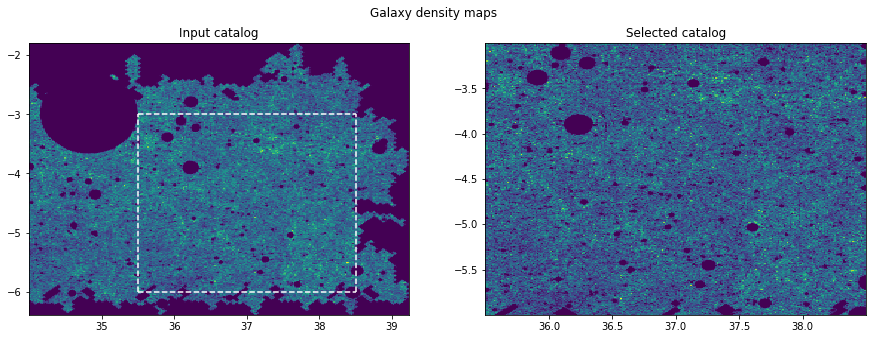

In [10]:
figure(figsize=[15,5])
subplot(121)
title('Input catalog')
hist2d(cat['ira'], cat['idec'], 256);
hlines(y=-3,xmin=35.5, xmax=38.5, color='w', linestyle='--')
hlines(y=-6,xmin=35.5, xmax=38.5, color='w', linestyle='--')
vlines(x=35.5,ymin=-6, ymax=-3, color='w', linestyle='--')
vlines(x=38.5,ymin=-6, ymax=-3, color='w', linestyle='--')

subplot(122)
hist2d(cat['ira'][survey_cut], cat['idec'][survey_cut], 256);
title('Selected catalog')
cat = cat[survey_cut]
suptitle('Galaxy density maps');

The plot above shows us where galaxies in our sample are distributed on the sky, the holes correpond to either regions that have not been fully surveyed yet, or that are masked because of the presence of a bright star.

Another important aspect of the sample, from the analysis point of view, is to determine the redshift distribution of our galaxies, which determines how much lensing we should expect. We will just use a rough estimate here using the MLZ redshifts included in the catalog, and mostly only care about the mean redshift (**Note**: this is an overly simpltistic redshift determination, do not use directly for a science paper.)

Mean redshift 0.9701822


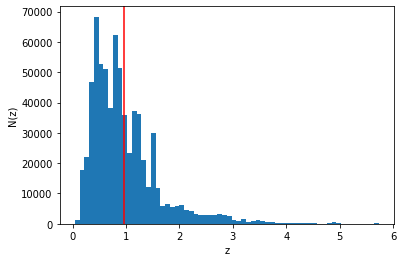

In [11]:
hist(cat['photoz_best'], 64);
xlabel('z')
ylabel('N(z)')
axvline(mean(cat['photoz_best']),color='red')
print('Mean redshift', np.mean(cat['photoz_best']))

This plot tells us that the mean redshift of our sample is z=1. This will be important for later ;-)

### Applying shear calibration

In the introduction we oversimplified the relationship between observed ellipticity and shear. In practice it is necessary to calibrate this relation. This is for instance described in [Oguri et al. 2017](https://arxiv.org/abs/1705.06792).

In [14]:
# We need to convert ellipticity to shear and calibrate it
# Step I: computing the shear responsivity
R = 1 - np.sum( cat['ishape_hsm_regauss_derived_shape_weight'] *
                cat['ishape_hsm_regauss_derived_rms_e']**2) / np.sum(cat['ishape_hsm_regauss_derived_shape_weight'])

# Step II: computing mean multiplicative bias factor
mbar = np.sum( cat['ishape_hsm_regauss_derived_shape_weight'] *
               cat['ishape_hsm_regauss_derived_shear_bias_m']) / np.sum(cat['ishape_hsm_regauss_derived_shape_weight'])

cat['gamma1'] = 1./(1+mbar)*(cat['ishape_hsm_regauss_e1']/(2 * R) -
                             cat['ishape_hsm_regauss_derived_shear_bias_c1'])

cat['gamma2'] = 1./(1+mbar)*(cat['ishape_hsm_regauss_e2']/(2 * R) -
                             cat['ishape_hsm_regauss_derived_shear_bias_c2'])

The important point of what happens here is that these new columns that we will call $\gamma_{obs}$, derived from measured ellipticities `ishape_hsm_regauss_e1/2` should now follow the relation:
$$\gamma_{obs} = \gamma + n$$
where $n$ is again assumed to be a Gaussian noise.

### Creating maps of binned ellipticity

Our next step is to create maps by binning the ellipticities of galaxies on a grid using the [lenspack](https://github.com/CosmoStat/lenspack/tree/master/lenspack) library.

In [16]:
from lenspack.utils import bin2d
from quarks2cosmos.utils import get_extend_radec

# Compute boundaries of the field so that it fits in a 360x360 map
# MassiveNuS maps beging 512x512 with 0.4 arcmin resolution, we resize them to 360x360
resolution = 512/360*0.4                     # Pixel resolution in arcmin/pixel
pixel_size = np.pi * resolution / 180. / 60. # Pixel resolution in rad/pixel

width = 360                                  # Number of pixels in output map
size = width * resolution / 60.              # Angular size of output map in deg.

# Compute center of the catalog
ra = median(cat['ira'])
dec = median(cat['idec'])

# Determine extent of our map
extent = [ra - size/2, ra + size/2, dec - size/2, dec + size/2]

**Number of galaxy per pixel map**

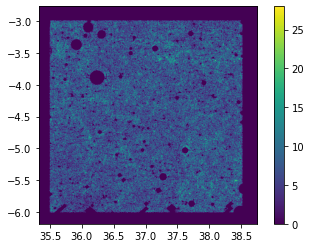

In [17]:
# Make a map of number of galaxies per pixels
n_gal_map = bin2d(cat['ira'], cat['idec'], npix=width, extent=extent)
imshow(n_gal_map, origin='lower', extent=get_extend_radec(resolution, width,ra, dec)); colorbar()

**Survey mask**

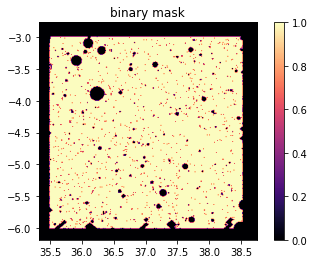

In [18]:
# Compute survey mask indicating regions where no galaxies are observed
m = n_gal_map == 0
mask = 1. - m
imshow(mask, cmap='magma', origin='lower', extent=get_extend_radec(resolution, width, ra, dec))
colorbar()
title("binary mask")
mask = np.expand_dims(mask, -1)

**Ellipticity maps**

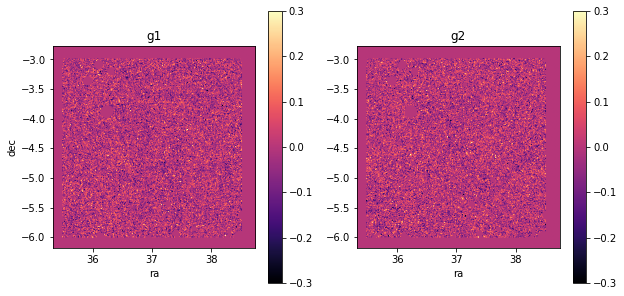

In [38]:
# Bin ellipticity components based on galaxy position into a 360x360 map
g1map, g2map = bin2d(cat['ira'], cat['idec'], 
                     v=(cat['gamma1'], cat['gamma2']), 
                     w=cat['ishape_hsm_regauss_derived_shape_weight'],
                     npix=width,
                     extent=extent)

figure(figsize=[10,5])
subplot(121)
imshow(g1map, cmap='magma', origin='lower', extent=get_extend_radec(resolution, width, ra, dec),vmin=-0.3,vmax=0.3)
colorbar()
xlabel('ra')
ylabel('dec')
title('g1')

subplot(122)
imshow(g2map, cmap='magma', origin='lower', extent=get_extend_radec(resolution, width, ra, dec),vmin=-0.3,vmax=0.3)
colorbar()
xlabel('ra')
title('g2')

# This will act as our input data
g_obs = np.stack([g1map, g2map], axis=-1)

**Noise covariance matrix**

<ipython-input-40-2b54ea24d119>:2: RuntimeWarning: divide by zero encountered in true_divide
  sigma_g1 = np.std(cat['gamma1'])/np.sqrt(n_gal_map)
<ipython-input-40-2b54ea24d119>:4: RuntimeWarning: divide by zero encountered in true_divide
  sigma_g2 = np.std(cat['gamma2'])/np.sqrt(n_gal_map)


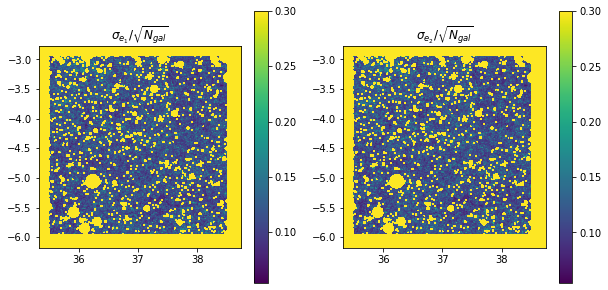

In [40]:
m = n_gal_map == 0
sigma_g1 = np.std(cat['gamma1'])/np.sqrt(n_gal_map)
sigma_g1[m] = 1e3 # Setting unobserved pixels to high noise
sigma_g2 = np.std(cat['gamma2'])/np.sqrt(n_gal_map)
sigma_g2[m] = 1e3 # Setting unobserved pixels to high noise

figure(figsize=[10, 5])
subplot(121)
imshow(sigma_g1, extent=get_extend_radec(resolution, width, ra, dec),vmax=0.3)
title(r'$\sigma_{e_1}/\sqrt{N_{gal}}$')
colorbar()

subplot(122)
imshow(sigma_g2, extent=get_extend_radec(resolution, width, ra, dec),vmax=0.3)
title(r'$\sigma_{e_2}/\sqrt{N_{gal}}$')
colorbar()

# This will be our estimate of the noise covariance in the shear map
g_obs_std = jnp.stack([sigma_g1, sigma_g2],axis=-1)

0.2834678069761526 0.2881893


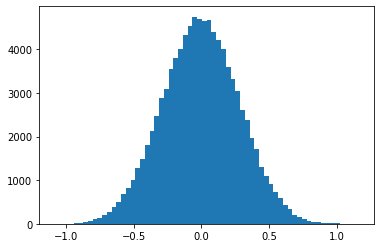

In [37]:

hist(g1map[~m]*sqrt(n_gal_map[~m]),64);
print(std(g1map[~m]*sqrt(n_gal_map[~m])), std(cat['gamma2']))
#hist(g2map[~m],64);


## Kaiser-Squires solution

Use the first mass-mapping technique [Kaiser-Squires (1993)](https://ui.adsabs.harvard.edu/abs/1993ApJ...404..441K/abstract). Smooth the solution with a gaussian filter.

In [178]:
from quarks2cosmos.lensing import ks93, ks93inv, measure_power_spectrum
from scipy.ndimage import gaussian_filter

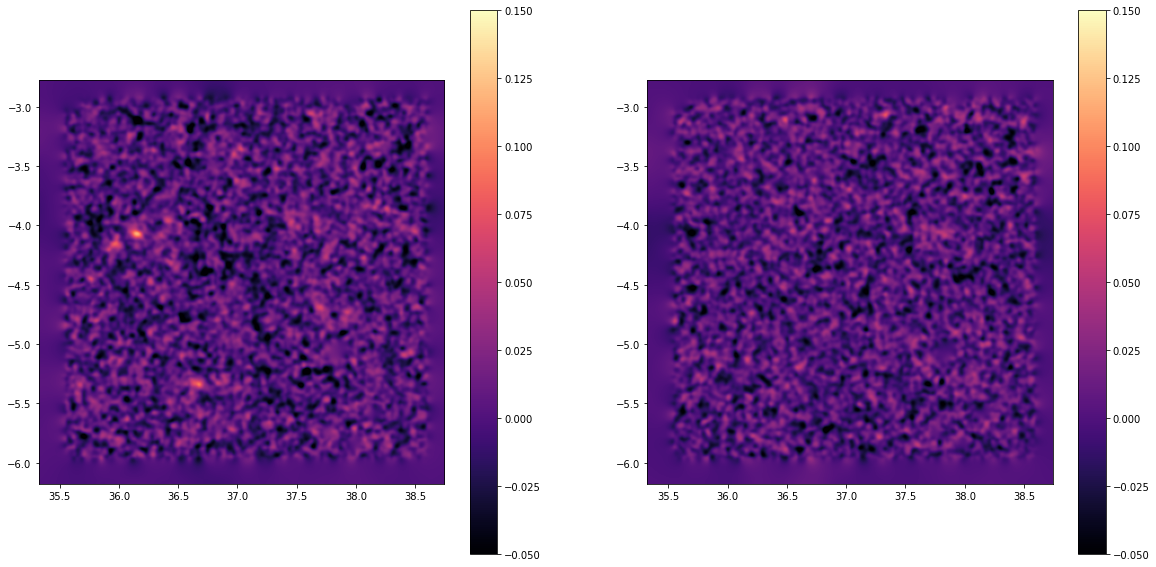

In [179]:
kappaE, kappaB = ks93(e1map, e2map)

kwargs = dict(vmin=-.05, vmax=.15, cmap='magma', extent=get_extend_radec(resolution, width, ra, dec))
figure(figsize=[20,10])
subplot(121)
imshow(gaussian_filter(kappaE,2)[:,::-1], **kwargs);colorbar()
subplot(122)
imshow(gaussian_filter(kappaB,2)[:,::-1], **kwargs);colorbar()

## Wiener filter solution

Get the maximum-a-posteriori (MAP), assuming a Gaussian prior that is characterised by the theoretical power spectrum.

In [180]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

1) The likelihood

In [185]:
def likelihood_fn(x):
    """ Likelihood function at the level of the measured shear
    """
    # Extract E and B mode maps
    ke = x[...,0].reshape((360, 360))
    kb = x[...,1].reshape((360, 360))
    
    # Forward model the shear
    model_shear = jnp.stack(ks93inv(ke, kb), axis=-1)
    
    likelihood = tfd.Independent(tfd.Normal(model_shear, sigma_data), 
                                 reinterpreted_batch_ndims=3)
    return likelihood

data_likelihood = likelihood_fn(jnp.stack([kappaE, kappaB], axis=-1))
#likelihood_score = jax.vmap(jax.grad(log_likelihood), in_axes=[0,0, None, None])
data_likelihood.log_prob(meas_shear)

DeviceArray(-291554.28, dtype=float32)

2) Build a Gaussian prior from the Power Spectrum (computed from [jax-cosmo](https://github.com/DifferentiableUniverseInitiative/jax_cosmo))

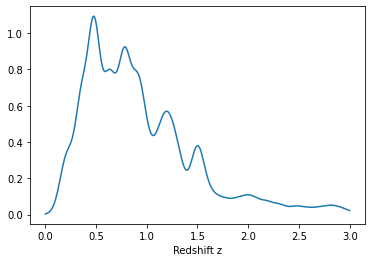

In [182]:
import jax_cosmo as jc
pz = jc.redshift.kde_nz(jnp.array(cat['photoz_best'][:10000].astype('float32')),
                        jnp.ones(10000), bw=0.05)
z = jnp.linspace(0,3,256)
plot(z, pz(z));
xlabel('Redshift z');

In [149]:
cosmo = jc.Planck15()
tracer = jc.probes.WeakLensing([pz])
ell = jnp.logspace(2,5)
cl  = jc.angular_cl.angular_cl(cosmo, ell, [tracer])

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5770: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


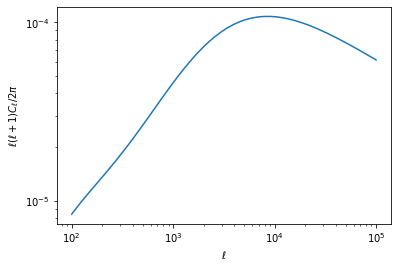

In [150]:
loglog(ell, ell * (ell + 1) * cl[0] / 2 / np.pi)
xlabel(r'$\ell$')
ylabel(r'$\ell  (\ell + 1) C_\ell / 2 \pi$');

In [151]:
ps_data_th = jnp.stack([ell, cl[0]],axis=0)

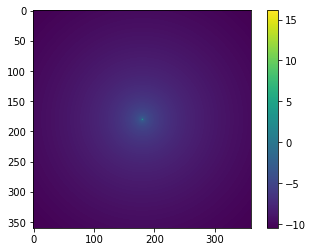

In [153]:
from quarks2cosmos.lensing import make_power_map
power_map_th = np.array(make_power_map(ps_data_th, size=360, pixel_size=pixel_size, ell=True))
imshow(np.log(jnp.fft.fftshift(power_map_th))); colorbar();

In [364]:
def log_gaussian_prior(x, sigma_temp=0.):
    """
    map_data: array on which to evaluate the log prior
    sigma: temperature
    ps_map: 
    """
    kE_ft = jnp.fft.fft2(x[...,0]) / 360. # Normalisation by size of map
    kB_ft = jnp.fft.fft2(x[...,1]) / 360.
    k_ft = jnp.stack([kE_ft, kB_ft],axis=-1)
    
    # Very low power expected on kB
    variance = jnp.stack([power_map_th, jnp.ones_like(power_map_th)*1e-9],axis=-1) + sigma_temp**2
    
    return -0.5*jnp.sum(jnp.abs(k_ft*jnp.conj(k_ft)) / (variance))

In [365]:
log_gaussian_prior(jnp.stack([kappaE, kappaB], axis=-1))

DeviceArray(-7.646109e+11, dtype=float32)

3) Compute the MAP

In [366]:
from functools import partial

def log_posterior(x):
    """ Compute the total posterior.
    """
    return likelihood_fn(x).log_prob(meas_shear) +  log_gaussian_prior(x)

In [367]:
# First try, let's try to find a maximum likelihood solution
import optax
optimizer = optax.adam(0.01)

In [368]:
# Create a parameter
x = jnp.zeros([360, 360, 2])
opt_state = optimizer.init(x)

In [369]:
# write an update function
@jax.jit
def update(x, opt_state):
    logp, grads = jax.value_and_grad(log_posterior)(x)
    updates, opt_state = optimizer.update(-grads, opt_state)
    x = optax.apply_updates(x, updates)
    return logp, x, opt_state

In [370]:
losses = []

In [371]:
for i in range(1000):
    logp, x, opt_state = update(x, opt_state)
    losses.append(logp)

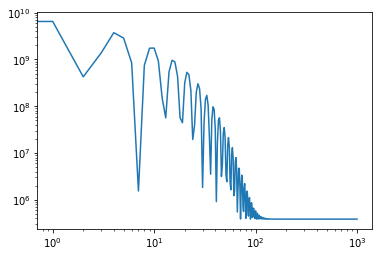

In [372]:
loglog(abs(np.array(losses)))

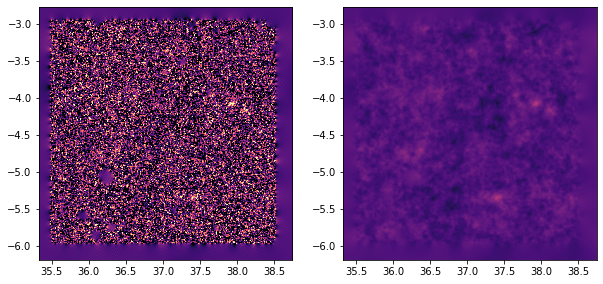

In [373]:
figure(figsize=[10,5])
subplot(121)
imshow(kappaE,**kwargs)
subplot(122)
imshow(x[...,0],**kwargs);

In [406]:
ell, ps_data = measure_power_spectrum(kappaE, 
                                      pixel_size=pixel_size)
ell, ps_filtered = measure_power_spectrum(x[...,0], 
                                          pixel_size=pixel_size)

cl_map  = jc.angular_cl.angular_cl(cosmo, ell, [tracer])

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5770: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


(200.0, 20000.0)

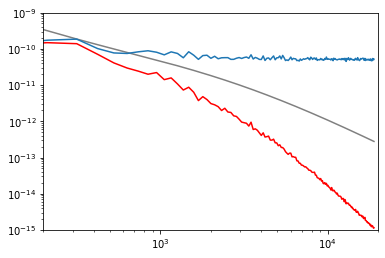

In [408]:
loglog(ell, cl_map[0]/(2 * pi),color='gray')
loglog(ell, ps_data/(2 * pi))
loglog(ell, ps_filtered/(2 * pi),color='red')
ylim(1e-15,1e-9)
xlim(2e2,2e4)

## Can we do better with Machine Learning?


### Load the MassiveNuS convergence dataset

See http://www.columbialensing.org/#massivenus for more information

In [420]:
import tensorflow as tf
import tensorflow_datasets as tfds
import jax_lensing

In [421]:
def map_fn(example):
    # Apply data augmentation
    k = tf.expand_dims(example['map'], -1)
    k = tf.image.flip_left_right(k)
    k = tf.image.flip_up_down(k)
    
    # Apply image reampling to 360x360 but preservin
    k = tf.image.resize(k, [360, 360], 
                        method=tf.image.ResizeMethod.AREA)
    
    # Removing batch dimension
    return k[...,0]

In [422]:
massive_nu = tfds.load('MassiveNu', split=tfds.Split.TRAIN)
massive_nu = massive_nu.map(map_fn)

In [423]:
dset = massive_nu.as_numpy_iterator()

In [424]:
m = next(dset)

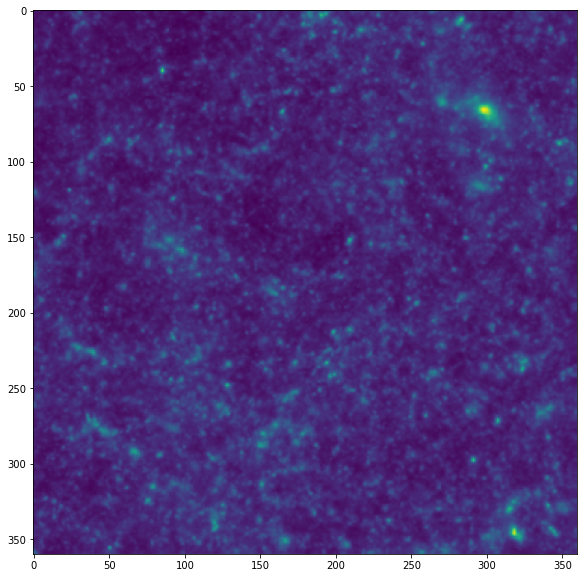

In [425]:
figure(figsize=[10,10])
imshow(m)